In [ ]:
""" in the end, we have: 
~53k venues
~58k foursquare users 
~27k of those users have twitter accounts
~22k of the users with twitter accounts have public profiles

only the 27k users with twitters profiles are included in the graph and in the analysis, 
the private profile users will simply have no social neighborhood 

the paper deleted venues with only 1 user check in (something we can consider as well)"""

In [5]:
from pymongo import MongoClient
import networkx as nx
import pandas as pd
import matplotlib as plt

In [6]:
client = MongoClient() # this stays the same and is the client 
db = client.gentrification #this is the database 
network_collection = db.users #this is a table in the database aka collection 

In [8]:
# load the time of visits for each visitor to a venue 
time=pd.read_csv("venue_visitors_withtime.csv", index_col=False)
time.columns = ["venue", "user", "time"]
user_details = pd.read_csv("userdetails.csv", index_col=False, header=None)
user_details.columns = ['user', 'twitter']
user_twitter_time=time.merge(user_details, on ="user", how = "left")

In [11]:
# user takes several photos in one visit and we take the first one 
user_twitter_time=user_twitter_time.sort_values("time").groupby(["venue", "user"]).first().reset_index() 

## adding nodes and edges for users

In [12]:
#initiating the graph 
G = nx.Graph()

In [15]:
"""for every document in the cursor, add user twitter handle to the network as a node 
and all of its friends as nodes. then add an edge between the user and its friends """
users_list = []
friends_list  = [] 
cursor = network_collection.find({}) #all records 
for document in cursor:
    #adding users to users list 
    user= "user: " + document['user']['twitterHandle']
    users_list.append(user)
    #adding friends to users list
    friends=["user: " + n for n in document['friends']]
    friends_list.extend(friends)
    #add nodes of the user and all of its friends 
    G.add_node(user)
    G.add_nodes_from(friends)
    #add edges between the user and its friends 
    edges=[[user,f] for f in friends]
    G.add_edges_from(edges)
     

## adding nodes and edges for venues

In [ ]:
"""this is the problematic function"""

import itertools

cursor = network_collection.find({})
for document in cursor: 
    user= "user: " + document['user']['twitterHandle'] 
    u= user[6:]
    venues = ["venue: " + n for n in document['venues']]
    for v in venues:
        venue=v[7:]
        #find the time of users visit to venue 
        t=(user_twitter_time['time'][(user_twitter_time['twitter']==u) & (user_twitter_time['venue']==venue)].values)[0]
        #add the edge between venue and user with time data
        G.add_edge(user, v, time = t)
        
    #add edges between venues if the user visited more than 1 venue 
    if len(venues) > 1: 
        for subset in itertools.combinations(venues, 2):
            venue1=subset[0][7:]
            venue2=subset[1][7:]
            #find the venue that is the latest visit from user 
            t1=(user_twitter_time['time'][(user_twitter_time['twitter']==u) & (user_twitter_time['venue']==venue1)].values)[0]
            t2=(user_twitter_time['time'][(user_twitter_time['twitter']==u) & (user_twitter_time['venue']==venue2)].values)[0]
            #if this edge already exists in the graph, then add the new latest time as a new weight of the edge, else simply add the edge with time
            if G.has_edge(subset[0], subset[1]) is True:
                G.get_edge_data(subset[0], subset[1])['time'].append(max(t1,t2))
            else:
                G.add_edge(subset[0], subset[1], time = [max(t1,t2)])
            
       


## separating the two layers 

In [ ]:
#define lists of venue nodes and user nodes 
venue_nodes = [n for n in G.nodes() if "venue: " in x]
user_nodes = [n for n in G.nodes() if "user: " in x]

## define general functions 

In [ ]:
def get_degrees(graph, node, hood):
    neighbors=graph.neighbors(node)
    if hood == "social":
        degrees=len([x for x in neighbors if "user: " in x])
    if hood == "place":
        degrees=len([x for x in neighbors if "venue: " in x])
    if hood == "all":
        degrees=len([x for x in neighbors])
    return degrees    

In [ ]:
def get_neighbors(graph, node, hood):
    if hood == "social":
        neighbors = [x for x in graph.neighbors(node) if "user: " in x]
    if hood == "user":
        neighbors = [x for x in graph.neighbors(node) if "user: " in x]
    if hood == "place":
        neighbors = [x for x in graph.neighbors(node) if "venue: " in x]   
    return neighbors    

In [ ]:
def neighborhood_size(graph,node,hops,hood):
    if hood == "social":
        neighbors = get_neighbors(graph, node, "social")
        size_1hop = len(neighbors)
        if hops == 1: 
            return size_1hop
        if hops == 2:
            all_nodes = neighbors
            for x in neighbors:
                neighbors_of_neighbors = get_neighbors(graph, node, "social")
                all_nodes.append(neighbors_of_neighbors)
            all_nodes=list(set(all_nodes)) 
            size_2hop = len(all_nodes)
            return size_2hop
        
    if hood == "place":
        neighbors = get_neighbors(graph, node, "place")
        size_1hop = len(neighbors)
        if hops == 1: 
            return size_1hop
        if hops == 2: #get all the neighbors' neighbors 
            all_nodes = neighbors
            for x in neighbors:
                neighbors_of_neighbors = get_neighbors(graph, node, "place")
                all_nodes.append(neighbors_of_neighbors)
            all_nodes=list(set(all_nodes))
            size_2hop = len(all_nodes)
            return size_2hop
                

## Brokerage 

In [ ]:
def effective_size_2hop(graph, node):
    """ first get all of the 2 hop social nodes in the network of the place """
    #find all neighbors of place
    ego_neighbors=get_neighbors(graph, node, "social")
    #find all neighbors of neighbors
    all_nodes = []
    all_nodes.extend(ego_neighbors)
    for n in ego_neighbors:
        neighbors_2hop = get_neighbors(graph, n, "social")
        all_nodes.extend(neighbors_2hop)
    all_nodes=list(set(all_nodes)) #drop duplicates 
    
    """ next make all possible pairs of nodes and check if there is an edge """
    count_edges_in_neighborhood = 0
    
    if len(all_nodes) > 1: 
        neighbors_pairs = []
        for subset in itertools.combinations(all_nodes, 2):
            neighbors_pairs.append(subset) # now i have all possible pairs in a list 
            
        #take the pairs list and check if the pairs are connected and do a count 
        for i in neighbors_pairs:
            if graph.has_edge(i[0],i[1]) is True:
                count_edges_in_neighborhood += 1 
                
    """ set up the equation """
    n = len(all_nodes)
    t = count_edges_in_neighborhood
    effectivesize = n - 2*t/n
    brokerage = effectivesize/n #this normalizes the effective size between 0 and 1
    return brokerage 

In [ ]:
# get the brokerage value of all venues here and store in a dict
brokerage_potential = {}
for node in venue_nodes:
    brokerage=effective_size_2hop(G,node)
    brokerage_potential[node] = brokerage


In [ ]:
B=pd.Series(brokerage_potential)
B.hist(bins=30)


In [ ]:
B_sin1=B[B!=1]

## Serendipity 

In [ ]:
def get_weighted_degrees(graph,node,neighbors):
    degrees = 0
    for i in neighbors:
        weight=len(list(set(graph.get_edge_data(node, i)['time'])))
        degrees += weight
    return degrees    

In [ ]:
#Serendipity measures the extent to which a venue can induce chance encounters 
def get_serendipity(graph,venue):
    """get all of the possible edges in the 2 hop spatial neighborhood of l,
    later for each user, we will get the weights before t"""
    spatial_1hop = get_neighbors(graph, venue, "place")
    all_edges = [[x,venue] for x in spatial_1hop]

    
    """ get the 2 hop social neighbors of l """
    neighbors1_of_place = get_neighbors(graph,venue,"social")
    all_neighbors_of_place = []
    all_neighbors_of_place.extend(neighbors1_of_place)
    for x in neighbors1_of_place:
        neighbors2_of_place = get_neighbors(graph, x, "social")
        all_neighbors_of_place.extend(neighbors2_of_place)
    social_hood_of_place = list(set(all_neighbors_of_place))
    
    """go through each user in the 2 hop neighborhood, grab the time of their check in to l,
    and filter out all edges after that time"""
    sum_of_probabilities = 0
    for user in social_hood_of_place:
    #find the time of when user checked into l
        if graph.has_edge(user,venue) is True:
            t=(user_twitter_time['time'][(user_twitter_time['twitter']==user[6:]) & (user_twitter_time['venue']==venue[7:])].values)[0]
        else: 
            t=200000000000
        #get all of the edges from u, 2 hop place neighborhood 
        place_neighborhood_of_user = []
        place_1hop_of_user = [n for n in graph.neighbors(user) if ("venue: " in n) & (n != venue)]
        place_neighborhood_of_user.extend(place_1hop_of_user)
        #find 2 hop neighbors 
        for p in place_1hop_of_user:
            place_2hop =[n for n in graph.neighbors(p) if ("venue: " in n) & (n != venue)]
            place_neighborhood_of_user.extend(place_2hop)
        #delete duplicates     
        place_neighborhood_of_user = list(set(place_neighborhood_of_user))
        #for every place in the neighborhood, check for when their connection was to l, if it's before t, then keep, if it's after, then filter out
        weights_v_l = 0
        for v in place_neighborhood_of_user: 
            if graph.has_edge(v,venue) is True:
                times_of_edge =list(set(list(G.get_edge_data(v, venue).values())[0])) #get the time(s) of edge from v to l 
                weight_before_t = len([x for x in times_of_edge if x < t]) # get how many of those times are before time t, and count, and that is the weight of the edge 
            else: 
                weight_before_t = 0
            
            weights_v_l += weight_before_t # numerator of probability 
        
        """get the total weight of the spatial network of l for user u before time t """
        total_weights = 0
        for edge in all_edges: 
            time_of_edge = list(set(list(graph.get_edge_data(edge[0], edge[1]).values())[0])) #list(set()) is to make sure no duplicated times 
            weight_before_t = len([x for x in time_of_edge if x < t])# get how many of those times are before time t, and count, and that is the weight of the edge 
            total_weights += weight_before_t # weights added
        
        if total_weights==0:
            probability = 0
        else:
            probability=weights_v_l/total_weights    

        sum_of_probabilities += probability
        #print(user, probability)
    serendipity=1- (sum_of_probabilities/len(social_hood_of_place))
    #print(sum_of_probabilities,len(social_hood_of_place) )
    return serendipity

In [ ]:
# get the brokerage value of all venues here and store in a dict
serendipity_value = {}
for node in venue_nodes:
    serendipity=get_serendipity(G,node)
    serendipity_value[node] = serendipity


In [ ]:
serendipity_value

In [ ]:
S=pd.Series(serendipity_value)
S.hist(bins=30)

## Entropy 

In [ ]:
# get the users and number of users for each venue 
# probability that a given visit in place is made by user u, take this multiply by the log of this probability and sum it for the entropy 
from scipy import stats
import math
def get_entropy(graph,venue):
    """if venue has no spatial network, then its entropy is zero and we cannot measure it"""
    place_neighbors = get_neighbors(graph,venue,"place")
    weighted_degrees_of_place = get_weighted_degrees(graph, venue, place_neighbors) 
    if weighted_degrees_of_place == 0:
        entropy = 0
    else:
        """find all users in the 2 hop social neighborhood of l"""
        social_1hop_of_place=get_neighbors(graph,venue,'social')
        social_nodes_2hop = []
        social_nodes_2hop.extend(social_1hop_of_place)
        for node in social_1hop_of_place: 
            hop2_neighbors = get_neighbors(graph, node, 'social')
            social_nodes_2hop.extend(hop2_neighbors)
        social_neighborhood_of_place=list(set(social_nodes_2hop)) #delete duplicates
        
        """for every user, compute probability""" 
        sum_of_probabilities = 0
        for i in social_neighborhood_of_place: 
            place_neighborhood_of_user = [n for n in graph.neighbors(i) if ("venue: " in n) & (n != venue) & ((n, venue) in graph.edges(n))]
            print(i, place_neighborhood_of_user)
            user_venues_weight=get_weighted_degrees(graph,venue,place_neighborhood_of_user)
            print(user_venues_weight)
            probability=user_venues_weight/weighted_degrees_of_place
            #print(i, probability)
            if probability == 0:
                x = 0
            else:    
                x= probability * math.log(probability) 
            #get the sum of probabilities     
            sum_of_probabilities += x
            #print(sum_of_probabilities)
        entropy = - sum_of_probabilities
        
    return entropy

        

In [ ]:
entropy_value = {}
for node in venue_nodes:
    entropy=get_entropy(G,node)
    entropy_value[node] = entropy


In [ ]:
E=pd.Series(entropy_value)
E.hist(bins=30)

## Homogeneity - using foursquare users

In [22]:
df_category=pd.read_csv('venues_barcelona_withdetails.csv', index_col = False)

#get categories of venues 
category=df_category[["id","category"]].values.tolist()
#category.append(["4e38e9c7d4c046ee86b4ed30", 'building'])
#category.append(["4e1304f2a809291902c455b6", 'shops'])
#category.append(["59d2e8a75ba0467e920b9974", "parks_outdoors"])

In [ ]:
from scipy import spatial
## get all visitors to a location 

def get_homogeneity(graph, venue):
    """get all of the users in the 2 hop social neighborhood"""
    social_neighborhood_of_place=get_neighbors(graph, venue, "user")
    all_social_nodes_2hop = [] 
    all_social_nodes_2hop.extend(social_neighborhood_of_place)
    for x in social_neighborhood_of_place:
        user_neighbors_ofhop2=get_neighbors(graph, x, "user")
        #keep only the 2nd hop nodes with venue visits 
        users_with_visits=[n for n in user_neighbors_ofhop2 if get_neighbors(graph, n, "place")] 
        all_social_nodes_2hop.extend(users_with_visits)
    social_nodes_2hop=list(set(all_social_nodes_2hop)) #delete duplicates
        
    """for each user in the 2hop, get their venues and venues categories, build frequency vector  """
    users_sim_dict = {}
    for user in social_nodes_2hop:
        place_neighborhood_of_user=[n[-24:] for n in graph.neighbors(user) if "venue: " in n]
        category_frequency = {"arts_entertainment" : 0, 
                           "building": 0, 
                           "education":0,  
                           "food" :0,
                           "nightlife"  :0,  
                           "parks_outdoors"  :0,
                           "shops" :0, 
                           "travel" :0,
                           "other" : 0}
        #for each venue get the category
        for venue in place_neighborhood_of_user:
            venue_category = [x[1] for x in category if venue in x[0]]
            category_frequency[venue_category[0]] += 1
        #turn the dict into a vector of values 
        user_visits_vector = list(category_frequency.values())
        t=sum(user_visits_vector)
        if t == 0: 
            user_frequency_vector = user_visits_vector
        else:     
            #normalize the frequencies
            user_frequency_vector =[x / t for x in user_visits_vector]
        #all users vectors into a dictionary 
        users_sim_dict[user] = user_frequency_vector
    # calculate cosine similarities of frequency vectors and then sum 
    #print(users_sim_dict)
    if len(users_sim_dict) > 1: 
        similarity_sum = 0 
        for subset in itertools.combinations(users_sim_dict.values(), 2):
            #print(subset)
            sim = 1 - spatial.distance.cosine(subset[0], subset[1])
            #print(subset, sim)
            similarity_sum += sim     
        homogeneity=2*similarity_sum/(len(social_nodes_2hop) * (len(social_nodes_2hop) - 1))
        #print(similarity_sum, homogeneity)
    else:
        homogeneity = None
        
    return homogeneity


In [ ]:
homogeneity_value = {}
for node in venue_nodes:
    homogeneity=get_homogeneity(G,node)
    homogeneity_value[node] = homogeneity


In [ ]:
H=pd.Series(homogeneity_value)
H.hist(bins=30)

## some analysis

In [551]:
#generate dataframe of all venue metrics 
df=pd.DataFrame({'venue':H.index, 'homogeneity':H.values, 'entropy':E.values, 'brokerage':B.values, 'serendipity':S.values})
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]



In [26]:
"""after creating dataframe with metrics, join with  """
#categories details df
venue_details=df_category[['id','category','category_detail','lat','lon','latlon','postalcode']].values.tolist()
dfc = pd.DataFrame([("venue: " + x[0], x[1], x[2], x[3], x[4], x[5], x[6]) for x in venue_details])
dfc.columns = ['venue', 'category','category_detail','lat','lon','latlon','postalcode' ]

#merge on detailed categories and dataframe
df=df.merge(dfc, on='venue', how="left")
df = df.drop_duplicates()

In [573]:
#check out values grouping by categories
category_groupby=df.groupby('category_detail').agg({"venue":"count",'brokerage': "mean", "serendipity":"mean"}).sort_values("brokerage", ascending= False)

In [574]:
#filter out those with less than 6 venues per category
category_groupby[["brokerage", "serendipity"]][ooo["venue"] > 6]

,brokerage,serendipity
category,,
'Monument / Landmark',0.934692,0.918363
'Train Station',0.925910,0.845340
'Mexican Restaurant',0.913966,0.849449
'Cultural Center',0.913337,0.879522
'Japanese Restaurant',0.904994,0.885924
'Music Venue',0.904438,0.846231
'Fast Food Restaurant',0.900500,0.836170
'Nightclub',0.894639,0.862121
'Theater',0.892109,0.849062


In [415]:
#take out brokerage values that are 1 
bsin1 = df[df["brokerage"]<1].copy()
bgraph=bsin1.groupby(["category"], as_index=False).agg({"brokerage": ["mean", 'std', "min","max"]})

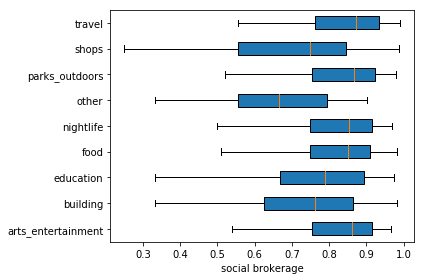

In [468]:
import matplotlib.pyplot as plt
import numpy as np


# groupby categories then array for the plot 
bplotarray=bsin1.groupby('category')['brokerage'].apply(list)

# Random test data
np.random.seed(19680801)
all_data = bplotarray.values
labels = bplotarray.index


# rectangular box plot
plt.boxplot(all_data,
            vert=False,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=labels,
            showfliers=False
           )  # will be used to label x-ticks
plt.xlabel("social brokerage")
plt.tight_layout()
#savefig('Bboxplot.png', )
plt.savefig('Bboxplot.png')

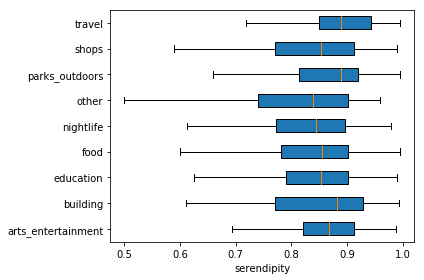

In [537]:
import matplotlib.pyplot as plt
import numpy as np


# groupby categories then array for the plot 
splotarray=cleandf.groupby('category')['serendipity'].apply(list)

# Random test data
np.random.seed(19680801)
all_data = splotarray.values
labels = splotarray.index


# rectangular box plot
plt.boxplot(all_data,
            vert=False,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=labels,
            showfliers=False
           )  # will be used to label x-ticks
plt.xlabel("serendipity")
plt.tight_layout()
#savefig('Bboxplot.png', )
plt.savefig('Sboxplot.png')

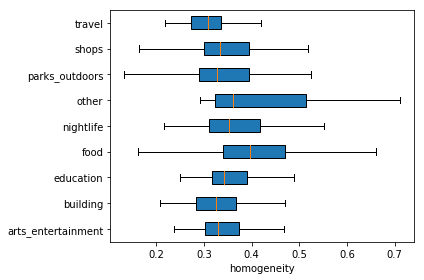

In [538]:
import matplotlib.pyplot as plt
import numpy as np


# groupby categories then array for the plot 
hplotarray=cleandf.groupby('category')['homogeneity'].apply(list)

# Random test data
np.random.seed(19680801)
all_data = hplotarray.values
labels = hplotarray.index


# rectangular box plot
plt.boxplot(all_data,
            vert=False,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=labels,
            showfliers=False
           )  # will be used to label x-ticks
plt.xlabel("homogeneity")
plt.tight_layout()
#savefig('Bboxplot.png', )
plt.savefig('Hboxplot.png')

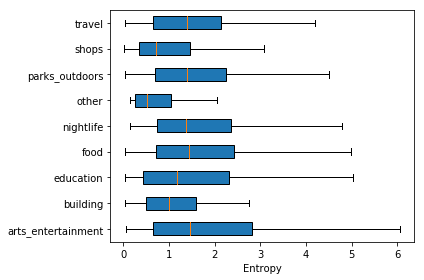

In [540]:
import matplotlib.pyplot as plt
import numpy as np


# groupby categories then array for the plot 
eplotarray=cleandf.groupby('category')['entropy'].apply(list)

# Random test data
np.random.seed(19680801)
all_data = eplotarray.values
labels = eplotarray.index


# rectangular box plot
plt.boxplot(all_data,
            vert=False,  # vertical box alignment
            patch_artist=True,  # fill with color
            labels=labels,
            showfliers=False
           )  # will be used to label x-ticks
plt.xlabel("Entropy")
plt.tight_layout()
#savefig('Bboxplot.png', )
plt.savefig('Eboxplot.png')

Text(0.5,0,'homogeneity')

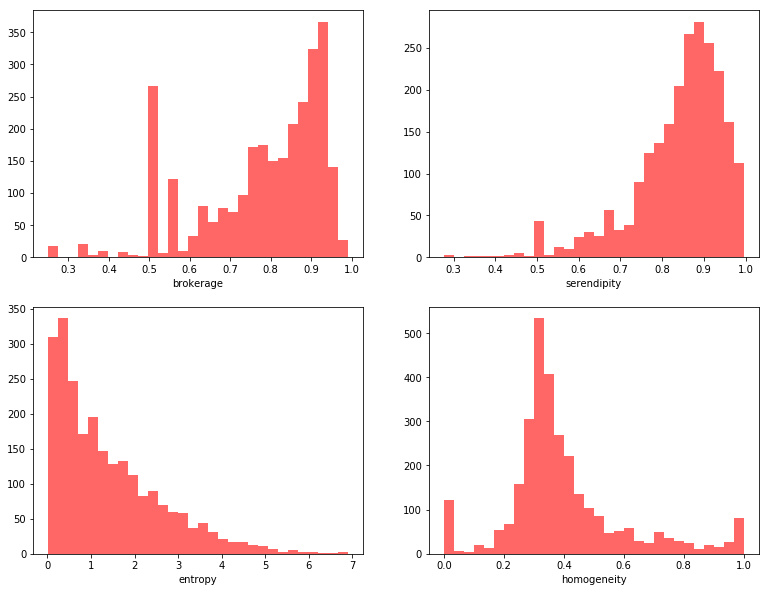

In [496]:
#taking out extreme values of 1 and 0  then graph 
cleandf = bsin1[(bsin1['serendipity']<1) & (bsin1['entropy']>0)].copy()
cleandf.dropna(inplace=True)

fig = plt.figure(figsize=(13,10))
names = ['brokerage', 'serendipity', 'entropy', 'homogeneity']

ax = fig.add_subplot(2,2,1)
ax.hist(bsin1['brokerage'], bins=30, color = "red", alpha = .6)
ax.set_xlabel("brokerage")


ax = fig.add_subplot(2,2,2)
ax.hist(df['serendipity'][df['serendipity']<1], bins=30, color = "red", alpha = .6)
ax.set_xlabel("serendipity")

ax = fig.add_subplot(2,2,3)
ax.hist(df['entropy'][df['entropy']>0], bins=30, color = "red", alpha = .6)
ax.set_xlabel("entropy")

ax = fig.add_subplot(2,2,4)
ax.hist(df['homogeneity'].dropna(), bins=30, color ="red", alpha = .6)
ax.set_xlabel("homogeneity")

### some graphs to describe relations between the metrics 

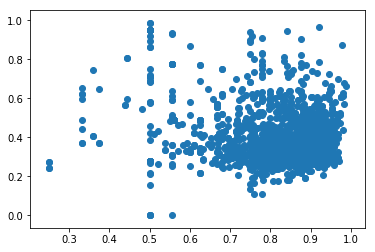

In [505]:
plt.scatter(cleandf["brokerage"],cleandf["homogeneity"])
plt.show()

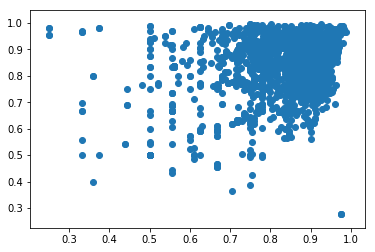

In [506]:
plt.scatter(cleandf["brokerage"],cleandf["serendipity"])
plt.show()

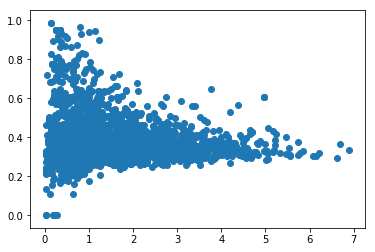

In [507]:
plt.scatter(cleandf["entropy"],cleandf["homogeneity"])
plt.show()

homogeneity vs brokerage relationship

In [510]:
import numpy as np
#group brokerage together into bins and take the mean of homogeniety and standard error in each group 
bins = np.linspace(cleandf['brokerage'].min(), cleandf['brokerage'].max(), 15)
groups = cleandf.groupby(pd.cut(cleandf['brokerage'], bins))
#df for brokerage and homogeneity relationship
b_h=pd.DataFrame(groups.mean().homogeneity)
b_h['std']=groups.std().homogeneity.values.tolist()
b_h.fillna(0)

,homogeneity,std
brokerage,,
"(0.494, 0.529]",0.560978,0.322686
"(0.529, 0.565]",0.509513,0.204850
"(0.565, 0.6]",0.380591,0.060887
"(0.6, 0.635]",0.419632,0.149139
"(0.635, 0.67]",0.437721,0.107269
"(0.67, 0.706]",0.397987,0.120299
"(0.706, 0.741]",0.386490,0.099766
"(0.741, 0.776]",0.395492,0.156467
"(0.776, 0.811]",0.391152,0.140205


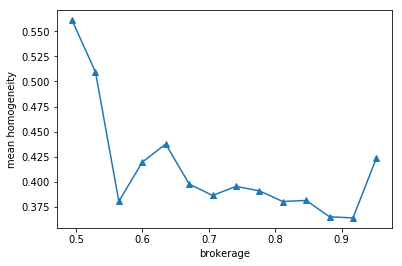

In [511]:
x = bins[0:14]
y = b_h['homogeneity'].tolist()

e = b_h['std'].tolist()
plt.errorbar(x, y, linestyle='-', marker='^')
plt.xlabel("brokerage")
plt.ylabel("mean homogeneity")
plt.show()


entropy and homogeneity relationship

In [513]:
#group entropy together into bins and take the mean of homogeneity and standard error in each group 
bins = np.linspace(cleandf.entropy.min(), cleandf.entropy.max(), 10)
groups = cleandf.groupby(pd.cut(cleandf.entropy, bins))
e_h=pd.DataFrame(groups.mean().homogeneity)
e_h['std']=groups.std().homogeneity.values.tolist()
e_h.fillna(0)

,homogeneity,std
entropy,,
"(0.0168, 0.782]",0.408746,0.171298
"(0.782, 1.547]",0.397887,0.123390
"(1.547, 2.312]",0.375260,0.084773
"(2.312, 3.077]",0.357290,0.060343
"(3.077, 3.841]",0.359874,0.064506
"(3.841, 4.606]",0.349557,0.048777
"(4.606, 5.371]",0.378087,0.088480
"(5.371, 6.136]",0.328792,0.032947
"(6.136, 6.901]",0.329584,0.030968


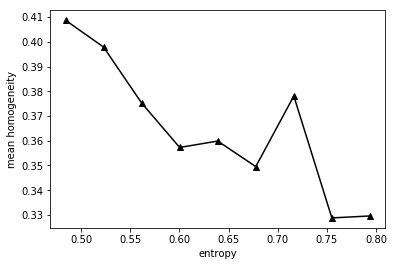

In [536]:
x = bins[0:9]
y = e_h['homogeneity'].tolist()
e = e_h['std'].tolist()
plt.errorbar(x, y, linestyle='-', marker='^', color = "black")
plt.xlabel("entropy")
plt.ylabel("mean homogeneity")
savefig('entropy_homogeneity.png') 
plt.show()

#plt.savefig('entropy_homogeneity.png')

brokerage and serendipity relationship

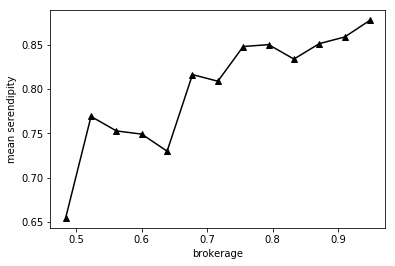

In [535]:
#group entropy together into bins and take the mean of homogeneity and standard error in each group 
bins = np.linspace(.484, cleandf.brokerage.max(), 14)
groups = cleandf.groupby(pd.cut(cleandf.brokerage, bins))
b_s=pd.DataFrame(groups.mean().serendipity)
b_s['std']=groups.std().serendipity.values.tolist()
b_s.fillna(0)

x = bins[0:13]
y = b_s['serendipity'].tolist()

e = b_s['std'].tolist()
plt.errorbar(x, y, linestyle='-', marker='^', color = "black")
plt.xlabel("brokerage")
plt.ylabel("mean serendipity")
savefig('brokerage_serendipity.png')
plt.show()

#plt.savefig('brokerage_serendipity.png')

degrees stats and ccdfs

In [321]:
#social network degree - to get all of the degrees in a social network for all social nodes \
social_degrees = [] 
for user in user_nodes:
    s_degree=get_degrees(G, user, "social")
    social_degrees.append(s_degree)

In [322]:
print("avg social degrees: ", round(sum(social_degrees)/len(social_degrees), 2))

avg social degrees:  4.1


In [324]:
# place netwrok degree - 
place_degrees = [] 
for place in venue_nodes:
    p_degree = get_degrees(G, place, "place")
    place_degrees.append(p_degree)

In [325]:
print("avg place degrees: ", round(sum(place_degrees)/len(place_degrees), 2))

avg place degrees:  27.4


In [303]:
## number of check - ins per user - proxy by # of venues per user 
user_venue_degrees = []
for user in user_nodes:
    v_degree=get_degrees(G, user, "place")
    user_venue_degrees.append(v_degree)

In [304]:
print("avg venues per user: ", round(sum(user_venue_degrees)/len(user_venue_degrees), 2))

avg venues per user:  2.33


In [305]:
## number of check - ins per venue - proxy by # of users per venue
venue_user_degrees = []
for venue in venue_nodes:
    u_degree = get_degrees(G, venue, "social")
    venue_user_degrees.append(u_degree)

In [306]:
print("avg users per venue: ", round(sum(venue_user_degrees)/len(venue_user_degrees), 2))

avg users per venue:  4.82


In [533]:
def plot_ccdf(data, ax):
    sorted_vals = np.sort(np.unique(data))
    ccdf = np.zeros(len(sorted_vals))
    n = float(len(data))
    for i, val in enumerate(sorted_vals):
        ccdf[i] = np.sum(data >= val)/n
    ax.plot(sorted_vals, ccdf, marker='o', color = "blue", alpha= .3)

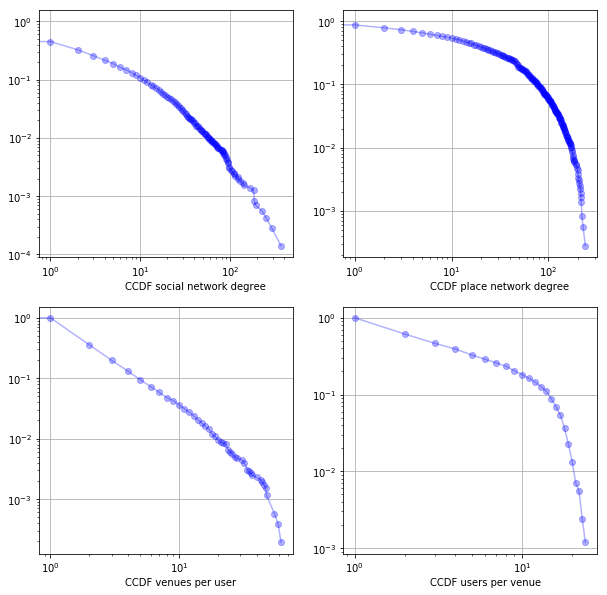

In [534]:
from matplotlib import *
import sys
from pylab import *

fig = plt.figure(figsize=(10,10))

degree_metrics = [social_degrees, place_degrees,user_venue_degrees, venue_user_degrees]
names = ['social network degree', 'place network degree', 'venues per user', 'users per venue']
for i, (data, name) in enumerate(zip(degree_metrics, names)):
    ax = fig.add_subplot(2,2,i+1)
    plot_ccdf(data, ax)
    ax.text(.34,-0.13, "CCDF " + name, transform=ax.transAxes)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid()
    
savefig('ccdf.png')   

In [326]:
all_degrees = []
for node in G.nodes():
    d = G.degree(node)
    all_degrees.append(d)

print("avg degrees: ", round(sum(all_degrees)/len(all_degrees), 2))

avg degrees:  14.84


In [339]:
geo_social = []
for node in venue_nodes:
    deg = get_degrees(G, node, "social")
    geo_social.append(deg)

In [341]:
for node in user_nodes:
    deg = get_degrees(G, node, "place")
    geo_social.append(deg)